In [1]:
%matplotlib inline
from numpy import *
from matplotlib.pyplot import *

Consider the following one-dimensional PDE:
$$
-u_{xx}(x) = f(x)\quad\mathrm{ in }\ \Omega = (0, \pi)
$$
$$
u(x) = 0, \quad\mathrm{ on }\ \partial\Omega = \{0, \pi\}
$$

Given the following $4^{th}$ order finite difference approximation of the second order derivative:

$$u_{xx}(x_i) = \frac{-u_{i-2}+16u_{i-1}-30u_i+16u_{i+1}-u_{i+2}}{12h^2}$$

Implement a function that given the domain interval, the forcing function, the number of discretization points (<b> equispaced ?</b>), the boundary conditions, returns the matrix $A$ and the the right hand side $b$.

In [4]:
def finDif(omega,f,n,bc):
    assert n >= 3 #at least the bounderies + 1 middle point
    assert type(omega) is list
    assert type(bc) is list
    assert len(omega) == 2
    assert len(bc) == 2
    assert omega[0] < omega[-1]
    
    # Get size of each subinterval  (𝑥𝑖,𝑥𝑖+1):
    h = 1./(n-1) 

    # Extract domain boundaries:
    start = omega[0]
    end = omega[-1]
    
    # Evaluate forcing function on grid points:
    x = linspace(start,end,n)
    b = f(x) #rhs
    
    # Using 4𝑡ℎ order FD of 2nd derivative:
    aij2 = 1*ones((n-2,)) # Second Offdiagonal entries
    aij1 = -16*ones((n-1,)) # First Offdiagonal entries
    aii = +30*ones((n,)) # Diagonal entries
    A = (diag(aij2, -2) + diag(aij1, -1) + diag(aii, 0) + diag(aij1, +1) + diag(aij2, +2))
    
    # Change first row of the matrix A and rhs
    A[0,:] = 0
    A[:,0] = 0
    A[0,0] = 1
    b[0] = bc[0]

    # Change last row of the matrix A and rhs
    A[-1,:] = 0
    A[:,-1] = 0
    A[-1,-1] = 1
    b[-1] = bc[-1]
    
    A /= 12*h**2
    
    return A, b

Call the function using:

In [5]:
omega = [0,pi]
f = lambda x : sin(x)
n=100
bc = [0,0]
A, b = finDif(omega, f, n, bc)

print(A)

[[   816.75      0.        0.   ...      0.        0.        0.  ]
 [     0.    24502.5  -13068.   ...      0.        0.        0.  ]
 [     0.   -13068.    24502.5  ...      0.        0.        0.  ]
 ...
 [     0.        0.        0.   ...  24502.5  -13068.        0.  ]
 [     0.        0.        0.   ... -13068.    24502.5       0.  ]
 [     0.        0.        0.   ...      0.        0.      816.75]]


Implement two functions that compute the LU and the Cholesky factorization of the system matrix $A$

In [6]:
def LU(A):
    A = A.copy()
    N=len(A)
    for k in range(N-1):
        if (abs(A[k,k]) < 1e-15):
            raise RuntimeError("Null pivot")
            
        A[k+1:N,k] /= A[k,k]
        for j in range(k+1,N):
            A[k+1:N,j] -= A[k+1:N,k]*A[k,j]
    
    L=tril(A)
    for i in range(N):
        L[i,i]=1.0
    U = triu(A)
    return L, U

L, U = LU(A)

In [7]:
def cholesky(A):
    """Performs a Cholesky decomposition of A, which must 
    be a symmetric and positive definite matrix. The function
    returns the lower variant triangular matrix, L."""
    A = A.copy()
    N = len(A)
    for k in range(N-1):
        A[k,k] = sqrt(A[k,k])
        A[k+1:N,k] = A[k+1:N,k]/A[k,k]
        
        for j in range(k+1,N):
            A[j:N,j] = A[j:N,j] - A[j:N,k]*A[j,k]
        
    A[-1,-1] = sqrt(A[-1,-1])
    L=tril(A)
    return L, L.transpose()

HT, H = cholesky(A)#upper triangular

Implement forward and backward substitution functions to exploit the developed factorization methods to solve the derived linear system of equations.

In [8]:
def L_solve(L,rhs):
    x = zeros_like(rhs)
    N = len(L)
        
    x[0] = rhs[0]/L[0,0]
    for i in range(1,N):
        x[i] = (rhs[i] - dot(L[i, 0:i], x[0:i]))/L[i,i]
    
    return x

In [9]:
def U_solve(U,rhs):
    x = zeros_like(rhs)
    N = len(U)
        
    x[-1] = rhs[-1]/U[-1,-1]
    for i in reversed(range(N-1)):
        x[i] = (rhs[i] - dot(U[i, i+1:N], x[i+1:N]))/U[i,i]
    
    return x

Solve the derived linear system using the implemented functions and plot the computed solution:

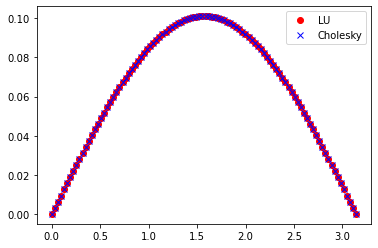

In [10]:
# Using LU
y = L_solve(L,b)
u_LU = U_solve(U,y)

# Using Cholesky
w = L_solve(HT,b)
u_Ch = U_solve(H,w)

x = linspace(omega[0],omega[-1],n)
_ = plot(x,u_LU,'ro', label='LU')
_ = plot(x,u_Ch,'bx', label='Cholesky')
_ = legend()

Considering the new domain $\Omega = (0,1)$ and the forcing term $f(x) = x(1-x)$ with B.C. $u(x) = 0$, on $\partial \Omega = {0,1}$ produce a plot and a table where you show the decay of the error w.r.t. the number of grid points.
(The analytical solution for the above problems is $u_{an} = \frac{x^4}{12} - \frac{x^3}{6} + \frac{x}{12}$)

Then with $ n \in (3, 300)$:

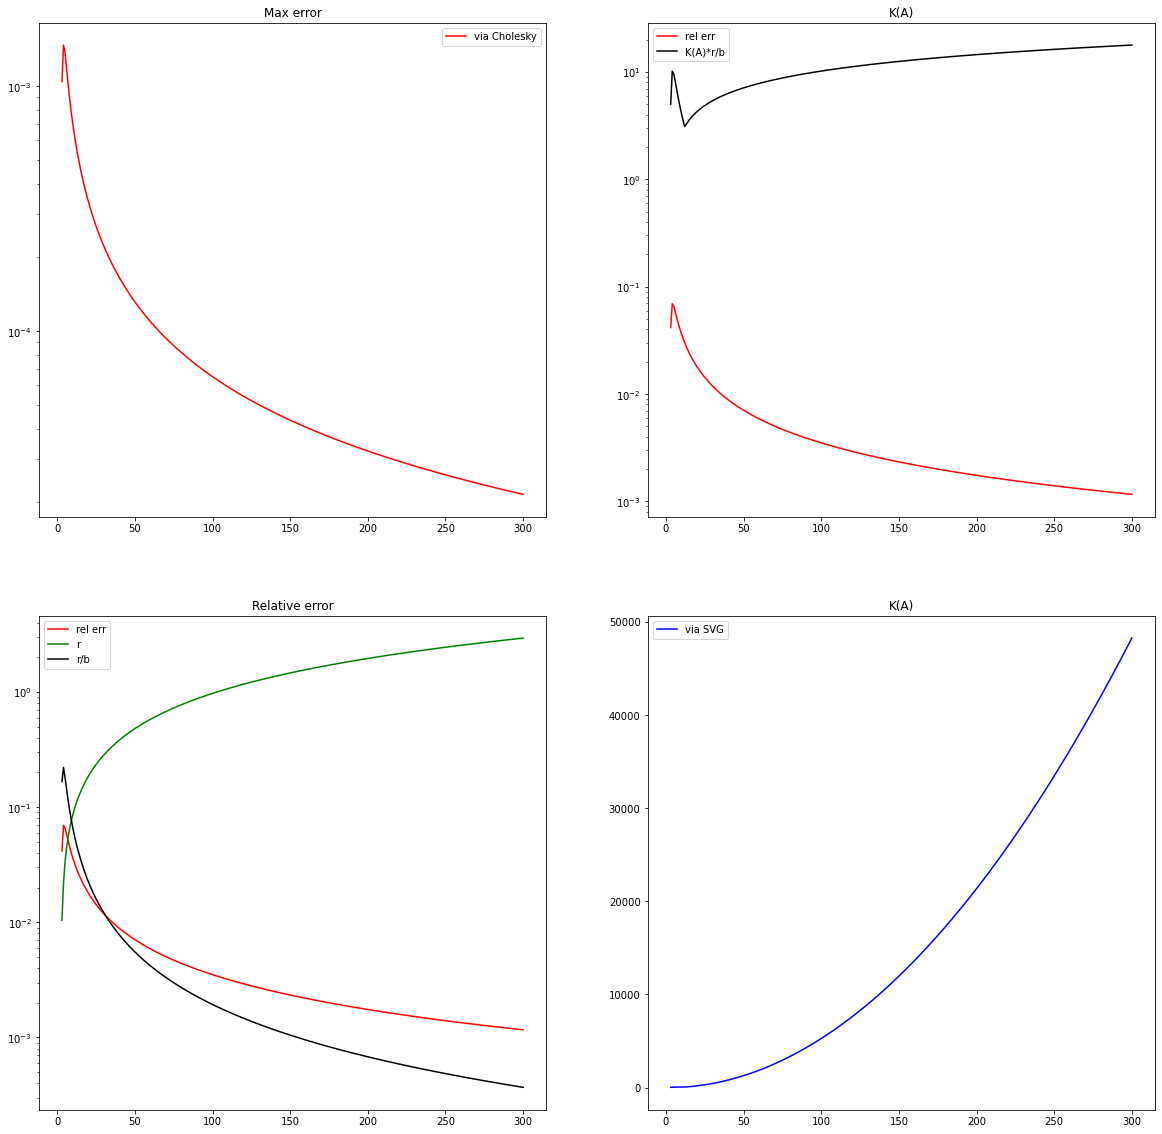

In [14]:
u_ex = lambda x : (x**4)/12. - (x**3)/6. + x/12.
omega = [0,1]
f = lambda x : x*(1.-x)
bc = [0,0]

N = range(3, 301)
max_errors = zeros(len(N))
cond_nums = zeros(len(N))
residuals = zeros(len(N))
rel_errors = zeros(len(N))
residuals_b = zeros(len(N))

for n in N:
    A, b = finDif(omega, f, n, bc)
    HT, H = cholesky(A)
    y = L_solve(HT,b)
    u = U_solve(H,y)
    x = linspace(omega[0],omega[-1],n)
    max_errors[n-3] = max(abs(u_ex(x)-u))
    cond_nums[n-3] = linalg.cond(A)
    residuals[n-3] = linalg.norm(b - dot(A,u_ex(x)),2)
    rel_errors[n-3] = linalg.norm(u_ex(x)-u,2)/linalg.norm(u,2)# euclidean norm
    residuals_b[n-3] = rel_errors[n-3]/linalg.norm(b,2)

#_ = semilogy(N,errors,'r', label='Cholesky')
#_ = legend()

figure, axis = subplots(2, 2, figsize = (16,8))
  
# For Max Errors
axis[0,0].semilogy(N,max_errors,'r', label='via Cholesky')
axis[0,0].set_title("Max error")

# For Relative Errors
axis[1,0].semilogy(N,rel_errors,'r', label='rel err')
axis[1,0].semilogy(N,residuals,'g', label='r')
axis[1,0].semilogy(N,residuals_b,'k', label='r/b')
axis[1,0].set_title("Relative error")

# For Condition number
axis[1,1].plot(N,cond_nums,'b', label='via SVG')
axis[1,1].set_title("K(A)")

# # For Gully
axis[0,1].semilogy(N,rel_errors,'r', label='rel err')
axis[0,1].semilogy(N,residuals_b*cond_nums,'k', label='K(A)*r/b')
axis[0,1].set_title("K(A)")

axis[0,0].legend(loc='best')
axis[1,0].legend(loc='best')
axis[1,1].legend(loc='best')
axis[0,1].legend(loc='best')
show()

The relative error infact is bounded by K(A):
$$
\frac{\| x - x_{true} \|}{\| x \|} \leq K(A) \frac{ \| r \|}{\| b \|}
$$

where the norm is the euclidean norm and r is the residual:
$$
r = b -Ax_{true}
$$

In [ ]:
print(max(max_errors))
argmax(max_errors) #n=4

0.0014697236919459233


1

Let's investigate for n=4:

0.0014697236919459233
[[  0.75   0.     0.     0.  ]
 [  0.    22.5  -12.     0.  ]
 [  0.   -12.    22.5    0.  ]
 [  0.     0.     0.     0.75]]
[0.         0.22222222 0.22222222 0.        ]


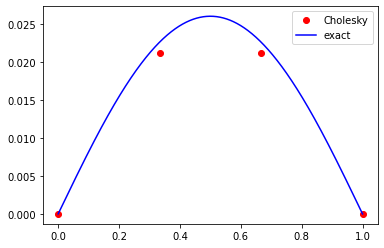

In [16]:
u_ex = lambda x : (x**4)/12. - (x**3)/6. + x/12.
omega = [0,1]
f = lambda x : x*(1.-x)
bc = [0,0]
n=4

A, b = finDif(omega, f, n, bc)
HT, H = cholesky(A)
y = L_solve(HT,b)
u = U_solve(H,y)
x = linspace(omega[0],omega[-1],n)
x_ex = linspace(omega[0],omega[-1],1000)
error = max(abs(u_ex(x)-u))
print(error)


#x = linspace(omega[0],omega[-1],n)
_ = plot(x,u,'ro', label='Cholesky')
_ = plot(x_ex,u_ex(x_ex), 'b', label='exact')
_ = legend()

print(A)
print(b)

Exploit the derived LU factorizations to compute the condition number of the system's matrix $A$ using the original problem formulation.

Recall:
$$
\| A \|_{p=2} = sup_{x \ne 0} \frac{ \| Ax \|_{p=2}}{\| x \|_{p=2}}
$$

But if A is sdp $\implies$
$$
K(A) = \frac{ \lambda_{max}}{\lambda_{min}}
$$

In [ ]:
import scipy.linalg

n=100
h = 1./(n-1)
omega = [0,pi]
f = lambda x : sin(x)
bc = [0,0]
A, b = finDif(omega, f, n, bc)
x=linspace(omega[0],omega[-1],n)



def PM(A,z0,tol=1e-5,nmax=500):
    q = z0/linalg.norm(z0,2)
    it = 0
    err = tol + 1.
    while it < nmax and err > tol:
        z = dot(A,q)
        l = dot(q.T,z)
        err = linalg.norm(z-l*q,2)
        q = z/linalg.norm(z,2)
        
        it += 1
    print("error =", err, "iterations =", it)
    print("lambda_max =", l)
    return l,q

def IPM(A,x0,mu,tol=1e-5,nmax=500):
    M = A - mu*eye(len(A))
    P,L,U = scipy.linalg.lu(M)
    q = x0/linalg.norm(x0,2)
    it = 0
    err = tol + 1.
    while it < nmax and err > tol:
        y = scipy.linalg.solve_triangular(L, dot(P.T,q), lower=True)
        x = scipy.linalg.solve_triangular(U,y)
        z = dot(A,q)
        l = dot(q.T,z)
        err = linalg.norm(z-l*q,2)
        q = x/linalg.norm(x,2)
        it += 1
    print("error =", err, "iterations =", it)
    print("lambda =", l)
    return l,q


def condNumb(A):
    #initilal guess
    z0 = ones_like(x)
    l_max,q_max = PM(A,z0)
    l_min,q_min = IPM(A,z0,6.)
    #L, U = LU(A)
    condNu = l_max/l_min
    return condNu

print(condNumb(A))
linalg.cond(A) #2-norm, computed directly using the SVD: 5278 -> very bad

error = 55.65117039403209 iterations = 500
lambda_max = 52189.470999034995
error = 6.011642319811925e-06 iterations = 6
lambda = 9.900512929600458
5271.390620883835


5278.068747923576

Implement a preconditioned Conjugant Gradient method to solve the original linear system of equations using an iterative method:

In [ ]:
def conjugate_gradient(A, b, P, nmax=len(A), eps=1e-10):
    x = zeros_like(b)
    tol = eps+1
    count = 0
    r = b - dot(A,x)
    rho_old = 1.
    p_old = zeros_like(b)
    
    while(count<nmax and tol>eps):
        count += 1
        z = linalg.solve(P,r)
        rho = dot(r,z)
        if(count > 1):
            beta = rho/rho_old
            p = z + beta*p_old
        else:
            p = z
        q = dot(A,p)
        alpha = rho/dot(p,q)
        x += p*alpha
        r -= q*alpha
        
        p_old = p
        rho_old = rho
        
        tol = linalg.norm(r,2)
        
    print(count, tol)
    return x

# Recall:
f = sin(x)
f[-1] = 0
f[0] = 0
# Solution by direct method
u = linalg.solve(A, f) #used for comparison with iter methods
# Solution by conjugate gradient
sol_gradient = conjugate_gradient(A, f, identity(len(A)))
print(linalg.norm(sol_gradient - u)/linalg.norm(u))
sol_preconditioned_gradient = conjugate_gradient(A, f, A)
print(linalg.norm(sol_preconditioned_gradient - u)/linalg.norm(u))


50 6.1772350238470435e-12
3.052776264642868e-14
1 1.9137306222266202e-12
2.6640386582648427e-14


Consider the following time dependent variation of the PDE starting from the orginal problem formulation:
$$
u'(t)-u_{xx} = \alpha(t)f(x)
$$

for $t\in [0,T]$, with $\alpha(t) = \cos(t)$ and $T = 6\pi$

Use the same finite difference scheme to derive the semi-discrete formulation and solve it using a forward Euler's method.

Plot the time dependent solution solution at $x = \pi/2$, $x=1$, 
$x=\pi$


In [ ]:
# Consider the following time dependent variation of the PDE starting from the orginal problem formulation:
# u'(t)-u_{xx} = alpha(t)f(x)
# for t in [0,T], with alpha(t) = cos(t) and T = 6*pi, and f(x) = sin(x) and x in [0,pi].
# Use the same finite difference scheme to derive the semi-discrete formulation:
# u_{i}^{n+1} - u_{i}^{n} = alpha(t_{n+1})h^{2}f(x_{i})/2
# for i = 1,2,...,n-1 and n = 0,1,...,N-1, where N is the number of time steps and h is the spatial step size.
# Use the same boundary conditions as in the original problem.
# Solve the semi-discrete problem for N = 100 and n = 1000.
# Plot the solution at t = 0, t = pi, t = 2*pi, t = 3*pi, t = 4*pi, t = 5*pi, and t = 6*pi.
# Compare the results with the exact solution.

def FinDif_t(omega, f, n, bc, T, alpha):
    assert n >= 3 #at least the bounderies + 1 middle point
    assert type(omega) is list
    assert type(bc) is list
    assert len(omega) == 2
    assert len(bc) == 2
    assert omega[0] < omega[-1]
    
    # Get size of each subinterval  (𝑥𝑖,𝑥𝑖+1):
    h = 1./(n-1) 

    # Extract domain boundaries:
    start = omega[0]
    end = omega[-1]
    
    # Evaluate forcing function on grid points:
    x = linspace(start,end,n)
    t = linspace(0,T,n)
    #rhs
    b = f(x)*alpha(t)
    
    # Using 4𝑡ℎ order FD of 2nd derivative:
    aij2 = 1*ones((n-2,)) # Second Offdiagonal entries
    aij1 = -16*ones((n-1,)) # First Offdiagonal entries
    aii = +30*ones((n,)) # Diagonal entries
    A = (diag(aij2, -2) + diag(aij1, -1) + diag(aii, 0) + diag(aij1, +1) + diag(aij2, +2))
    
    # Change first row of the matrix A and rhs
    A[0,:] = 0
    A[:,0] = 0
    A[0,0] = 1
    b[0] = bc[0]

    # Change last row of the matrix A and rhs
    A[-1,:] = 0
    A[:,-1] = 0
    A[-1,-1] = 1
    b[-1] = bc[-1]
    
    A /= 12*h**2
    
    # Add to A the forward derivative of u with respect to t for each point in the grid:
   # A += diag(ones((n,)), 0)


    return A,b



Given the original $Au = b$ system, implement an algorithm to compute the eigenvalues and eigenvectors of the matrix $A$. Exploit the computed LU factorization

The eigenvalues are:  [5.22555879e+04 5.22063779e+04 5.21244489e+04 5.20099324e+04
 5.18630119e+04 5.16839223e+04 5.14729499e+04 5.12304312e+04
 5.09567522e+04 5.06523472e+04 5.03176984e+04 4.99533340e+04
 4.95598271e+04 4.91377946e+04 4.86878952e+04 4.82108282e+04
 4.77073316e+04 4.71781804e+04 4.66241848e+04 4.60461879e+04
 4.54450644e+04 4.48217177e+04 4.41770785e+04 4.35121023e+04
 4.28277673e+04 4.21250720e+04 4.14050333e+04 4.06686839e+04
 3.99170701e+04 3.91512497e+04 3.83722895e+04 3.75812631e+04
 3.67792489e+04 3.59673273e+04 3.51465792e+04 3.43180834e+04
 3.34829145e+04 3.26421413e+04 3.17968241e+04 3.09480135e+04
 3.00967480e+04 2.92440523e+04 2.83909360e+04 2.75383914e+04
 2.66873925e+04 2.58388930e+04 2.49938255e+04 2.41530998e+04
 2.33176021e+04 2.24881936e+04 2.16657098e+04 2.08509597e+04
 2.00447247e+04 1.92477584e+04 1.84607860e+04 1.76845034e+04
 1.69195775e+04 1.61666458e+04 1.54263161e+04 1.46991666e+04
 1.39857461e+04 1.32865741e+04 1.26021410e+04 1.19329085e+04
 1

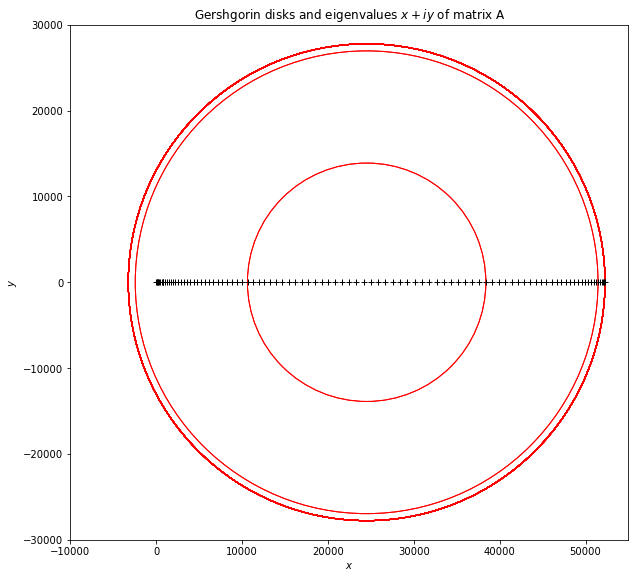

In [ ]:
#get gershgorin circle theorem to work:
import matplotlib.pyplot as plt

eigenvalues = np.linalg.eigvals(A)
print("The eigenvalues are: ", eigenvalues)

def gershgorin(A):
    #A is a square matrix
    n = len(A)
    r = zeros((n,))
    for i in range(n):
        r[i] = sum(abs(A[i,:])) - abs(A[i,i])
    return r
#print(gershgorin(A))

R = gershgorin(A)

def plotGershgorin(A):
    n = len(A)
    r = gershgorin(A)
    x = zeros((n,))
    y = zeros((n,))
    for i in range(n):
        x[i] = A[i,i].real
        y[i] = A[i,i].imag
    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    for i in range(n):
        circle = plt.Circle((x[i], y[i]), r[i], color='r', fill=False)
        ax.add_artist(circle)
        plt.plot(eigenvalues[i].real, eigenvalues[i].imag, 'k+')
    ax.axis([-10000, 55000, -30000, 30000])
    # Change width of image:
    fig.set_size_inches(10, 10)
    plt.xlabel("$x$")
    plt.ylabel("$y$")
    plt.title("Gershgorin disks and eigenvalues $x + iy$ of matrix A")
    return plt
    
plot1 = plotGershgorin(A)
#plot1.axis([0, 10000, -30000, 20000])
plot1.show()

# R = np.zeros(len(A)) # disk radii
# for i in range(len(A)):
#     R[i] = sum(abs(A[i,:])) - abs(A[i,i])

# # Plotting code
# fig, ax = plt.subplots()
# for k in range(len(A)):
#     x, y = A[k,k].real, A[k,k].imag
#     ax.add_artist( plt.Circle((x, y), R[k], alpha=0.5) )
#     plt.plot(eigenvalues[k].real, eigenvalues[k].imag, 'k+')

# ax.axis([-10000, 55000, -30000, 30000])
# ax.set_aspect(1)    
# plt.xlabel("$x$")
# plt.ylabel("$y$")
# plt.title("Gershgorin disks and eigenvalues $x + iy$")


In [ ]:
# Define a new matrix B with following entries:
B = np.matrix([[30,1,2,3],[4,15,-4,-2],[-1,0,3,5],[-3,5,0,-1]])
print(B.shape)
B

(4, 4)


matrix([[30,  1,  2,  3],
        [ 4, 15, -4, -2],
        [-1,  0,  3,  5],
        [-3,  5,  0, -1]])

The eigenvalues are:  [30.0400993  12.71191723 -1.61612272  5.86410619]
The radii are:  [ 6. 10.  6.  8.]


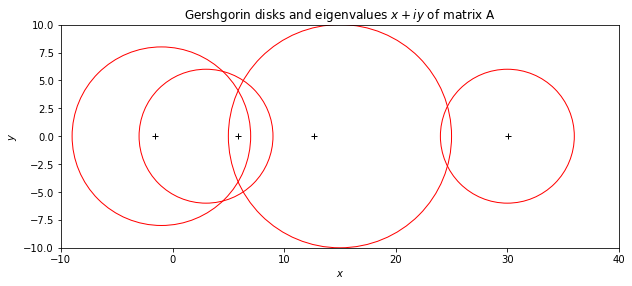

In [ ]:
eigenvalues_B = np.linalg.eigvals(B)
print("The eigenvalues are: ", eigenvalues_B)
r_B = gershgorin(B)
print("The radii are: ", r_B)
plot2 = plotGershgorin(B)
# Set axis limits:
plot2.axis([-10, 40, -10, 10])
# plot also the eigenvalues_B:
for i in range(len(B)):
    plot2.plot(eigenvalues_B[i].real, eigenvalues_B[i].imag, 'k+')
plot2.show()

In [ ]:
print(R.shape)
print(eigenvalues.shape)

(100,)
(100,)


In [ ]:
R

array([    0.  , 13884.75, 26952.75, 27769.5 , 27769.5 , 27769.5 ,
       27769.5 , 27769.5 , 27769.5 , 27769.5 , 27769.5 , 27769.5 ,
       27769.5 , 27769.5 , 27769.5 , 27769.5 , 27769.5 , 27769.5 ,
       27769.5 , 27769.5 , 27769.5 , 27769.5 , 27769.5 , 27769.5 ,
       27769.5 , 27769.5 , 27769.5 , 27769.5 , 27769.5 , 27769.5 ,
       27769.5 , 27769.5 , 27769.5 , 27769.5 , 27769.5 , 27769.5 ,
       27769.5 , 27769.5 , 27769.5 , 27769.5 , 27769.5 , 27769.5 ,
       27769.5 , 27769.5 , 27769.5 , 27769.5 , 27769.5 , 27769.5 ,
       27769.5 , 27769.5 , 27769.5 , 27769.5 , 27769.5 , 27769.5 ,
       27769.5 , 27769.5 , 27769.5 , 27769.5 , 27769.5 , 27769.5 ,
       27769.5 , 27769.5 , 27769.5 , 27769.5 , 27769.5 , 27769.5 ,
       27769.5 , 27769.5 , 27769.5 , 27769.5 , 27769.5 , 27769.5 ,
       27769.5 , 27769.5 , 27769.5 , 27769.5 , 27769.5 , 27769.5 ,
       27769.5 , 27769.5 , 27769.5 , 27769.5 , 27769.5 , 27769.5 ,
       27769.5 , 27769.5 , 27769.5 , 27769.5 , 27769.5 , 27769

Compute the inverse of the matrix A exploiting the derived LU factorization

In [ ]:
#TODO

Consider the following Cauchy problem
$$
\begin{cases}
y'= -ty^2 \quad 0\le t \le 2\\
y(0) = 1
\end{cases}
$$
Implement a Backward Euler's method in a suitable function and solve the resulting non-linear equation using a Newton's method.

In [ ]:
#TODO